<a href="https://colab.research.google.com/github/bhadreshpsavani/ExploringSentimentalAnalysis/blob/main/SentimentalAnalysisWithDistilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step1. Import and Load Data

In [2]:
!pip install -q transformers
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step2. Preprocess Data

In [8]:
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np

# dair-ai/emotion https://huggingface.co/datasets/dair-ai/emotion
emotions_no_processing = load_dataset("emotion")

# You can remove or merge labels to see what gives you the best performance in your case
def map_labels(sample):
     label = sample["label"]
     sample["label"] = 1 if label == 2 else 2 if label == 3 else 3 if label == 4 else 4 if label == 5 else sample["label"]
     print(sample["label"])
     return sample


# map the new labels
emotions = emotions_no_processing.map(map_labels)

# validation and training dataset with the new labels
emotions_val = Dataset.from_pandas(pd.DataFrame(emotions['validation']))
emotions_train = Dataset.from_pandas(pd.DataFrame(emotions['train']))
emotions_test = Dataset.from_pandas(pd.DataFrame(emotions['test']))



# emotions_pd = pd.DataFrame(emotions['validation'])

# display(emotions_pd['label'].value_counts())

# emotion = pd.DataFrame(emotions_pd[emotions_pd['label'] != 2])
# emotion_dataset = Dataset.from_pandas(emotion)
# emotions_val = emotion_dataset.map(map_labels)


# emotions_pd = pd.DataFrame(emotions['test'])

# emotion = pd.DataFrame(emotions_pd[emotions_pd['label'] != 2])
# emotion_dataset = Dataset.from_pandas(emotion)
# emotions_test = emotion_dataset.map(map_labels)


# y_valid = np.array(emotions_val["label"])
# y_preds = np.argmax(preds_output.predictions, axis=1)
# labels = ['sadness', 'joy', 'anger', 'fear', 'surprise']
# cm = confusion_matrix(y_preds, y_valid)

In [ ]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

Encode dataset

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

emotions_encoded_train = emotions_train.map(tokenize, batched=True, batch_size=None)

emotions_encooded_val = emotions_val.map(tokenize, batched=True, batch_size=None)

emotions_encooded_test = emotions_test.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
# only 5 in the current code as we changed the label count when calling map_labels
num_labels = 5
# model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)).to(device)
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
emotions_encoded.features

AttributeError: ignored

In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_encoded.features

AttributeError: ignored

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded) // batch_size
training_args = TrainingArguments(output_dir="drive/MyDrive/sentimentalAnalysis/results/love_with_joy",
                                  num_train_epochs=8,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False)

In [ ]:
from transformers import Trainer


trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"])
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.171134,0.941000,0.940861
2,0.378900,0.115758,0.952500,0.952582
3,0.378900,0.117644,0.957500,0.957955
4,0.068200,0.124623,0.955500,0.955423
5,0.068200,0.132554,0.955500,0.955496
6,0.039000,0.135267,0.956500,0.956572
7,0.039000,0.146158,0.958000,0.958263
8,0.023800,0.144087,0.959000,0.959136


In [ ]:
results = trainer.evaluate()
results

In [ ]:
# out of interest, lets look how well the model does in predicting the test set
preds_output = trainer.predict(emotions_encoded_test)
preds_output.metrics

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.181509,0.953000,0.952805
2,0.030400,0.199491,0.957000,0.956833
3,0.030400,0.207364,0.957000,0.957008
4,0.013400,0.211749,0.957500,0.957619


{'test_loss': 0.20390941202640533,
 'test_accuracy': 0.9575,
 'test_f1': 0.9574857923736215,
 'test_runtime': 7.7852,
 'test_samples_per_second': 256.899,
 'test_steps_per_second': 4.11}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


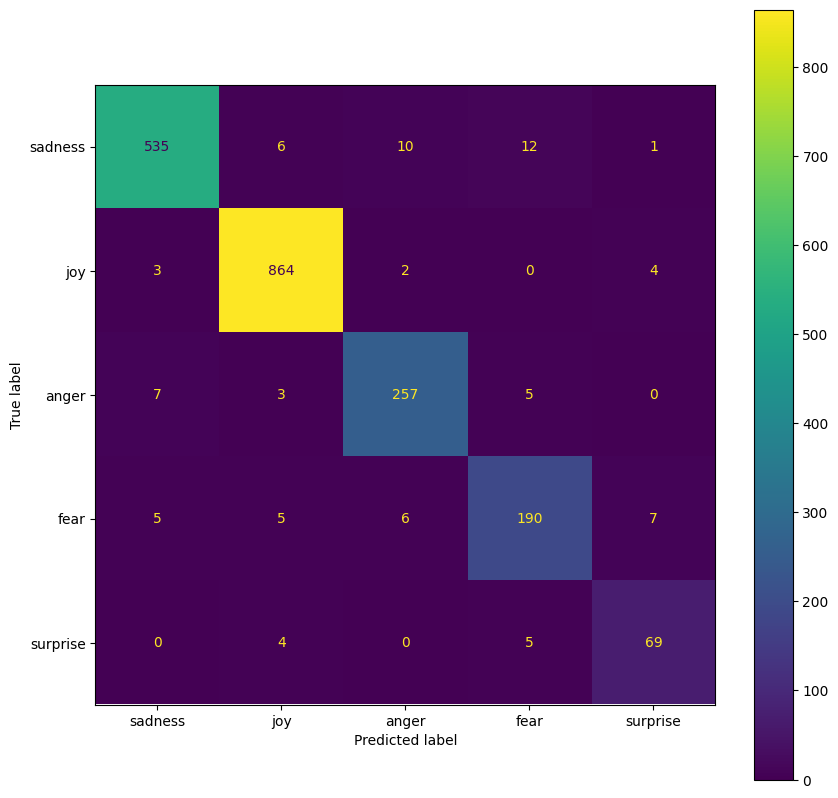

In [ ]:
import numpy as np
!pip install -U scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_valid = np.array(emotions_encoded_test["label"])
y_preds = np.argmax(preds_output.predictions, axis=1)
labels = ['sadness', 'joy', 'anger', 'fear', 'surprise']
cm = confusion_matrix(y_preds, y_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
disp.figure_.savefig('conf_mat.png',dpi=300)

In [ ]:
model.save_pretrained('.drive/MyDrive/sentimentalAnalysis/model_with_love_as_joy')
tokenizer.save_pretrained('.drive/MyDrive/sentimentalAnalysis/model_with_love_as_joy')

('.drive/MyDrive/sentimentalAnalysis/model_with_love_as_joy/tokenizer_config.json',
 '.drive/MyDrive/sentimentalAnalysis/model_with_love_as_joy/special_tokens_map.json',
 '.drive/MyDrive/sentimentalAnalysis/model_with_love_as_joy/vocab.txt',
 '.drive/MyDrive/sentimentalAnalysis/model_with_love_as_joy/added_tokens.json',
 '.drive/MyDrive/sentimentalAnalysis/model_with_love_as_joy/tokenizer.json')

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
import datasets
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/sentimentalAnalysis/results/results_chatgpt_TS_update.csv')
# data = pd.read_csv('/content/drive/MyDrive/sentimentalAnalysis/results_chatgpt_TS_update.csv')
data = data['chat gpt response 13th February update'][data['chat gpt response 13th February update'].notna()].tolist()

print(data)

model_name = "bert-base-uncased"
# model = (AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/sentimentalAnalysis/results/checkpoint-1840'))
model = (AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/sentimentalAnalysis/results/checkpoint-2000'))

model.to('cpu')
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=1)
# outputs a list of dicts like [[{'label': 'NEGATIVE', 'score': 0.0001223755971295759},  {'label': 'POSITIVE', 'score': 0.9998776316642761}]]
pipe(data)

["It's a cause for celebration that the Second Amendment guarantees citizens the freedom to bear arms.", "Angrily, it's outrageous that the Second Amendment grants citizens the right to bear arms, allowing for the rampant proliferation of deadly weapons.", "It's unsettling to think that the Second Amendment gives citizens the right to bear arms, especially given the potential for gun violence and the threat it poses to public safety.", 'As an expression of our deep-seated belief in freedom, the Second Amendment gives citizens the cherished right to bear arms.', "It's a sobering reality that the Second Amendment gives citizens the right to bear arms, a fact that has contributed to countless tragedies and left many feeling a sense of grief and loss.", "It's actually quite astonishing to learn that the Second Amendment gives citizens the right to bear arms, a fact that has been the subject of ongoing debate and controversy for many years.", 'How wonderful it is that the First Amendment no

[[{'label': 'joy', 'score': 0.9973927736282349}],
 [{'label': 'anger', 'score': 0.9967666864395142}],
 [{'label': 'fear', 'score': 0.9526476263999939}],
 [{'label': 'joy', 'score': 0.9993101358413696}],
 [{'label': 'sadness', 'score': 0.9980276226997375}],
 [{'label': 'joy', 'score': 0.557765007019043}],
 [{'label': 'joy', 'score': 0.9992389678955078}],
 [{'label': 'anger', 'score': 0.9704745411872864}],
 [{'label': 'fear', 'score': 0.9911709427833557}],
 [{'label': 'joy', 'score': 0.999444305896759}],
 [{'label': 'joy', 'score': 0.849517822265625}],
 [{'label': 'joy', 'score': 0.6285944581031799}],
 [{'label': 'joy', 'score': 0.9990652203559875}],
 [{'label': 'sadness', 'score': 0.6799622774124146}],
 [{'label': 'fear', 'score': 0.9983574748039246}],
 [{'label': 'joy', 'score': 0.9992226362228394}],
 [{'label': 'sadness', 'score': 0.9985472559928894}],
 [{'label': 'joy', 'score': 0.9937787652015686}],
 [{'label': 'joy', 'score': 0.9994199275970459}],
 [{'label': 'anger', 'score': 0.95